In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
import time


#from cnn_utils import *

%matplotlib inline
np.random.seed(1)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
classes = 2
X_train = np.expand_dims(np.load('X_train_full.npy'), axis = 3)
y_train = np.load('y_train_full.npy').flatten()
X_val = np.expand_dims(np.load('X_dev.npy'), axis = 3)
y_val = np.load('y_dev.npy').flatten()
X_test = np.expand_dims(np.load('X_test.npy'), axis = 3)
y_test = np.load('y_test.npy').flatten()


# construct log
X_train = np.log10(X_train)
X_test = np.log10(X_test)

# construct 1-hot vector
Y_test = np.zeros((y_test.shape[0], 2)) # 2 classes 
Y_test[np.arange(y_test.shape[0]), y_test] = 1

Y_val = np.zeros((y_val.shape[0], 2)) # 2 classes 
Y_val[np.arange(y_val.shape[0]), y_val] = 1

Y_train = np.zeros((y_train.shape[0], 2)) # 2 classes 
Y_train[np.arange(y_train.shape[0]), y_train] = 1

print('Y_test shape is: ', Y_test.shape)
print('y_test: ', y_test[:10])
print('Y_test: ', Y_test[:10])

Y_test shape is:  (5036, 2)
y_test:  [1 1 0 0 1 1 1 1 0 0]
Y_test:  [[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [3]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 82158
number of test examples = 5036
X_train shape: (82158, 205, 110, 1)
Y_train shape: (82158, 2)
X_test shape: (5036, 205, 110, 1)
Y_test shape: (5036, 2)


In [4]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    
    return X, Y

In [5]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
    ### Set up variables for W ###
    W1 = tf.get_variable("W1", [5, 5, 1, 32], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [5, 5, 32, 64], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W3 = tf.get_variable("W3", [5, 5, 64, 64], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W4 = tf.get_variable("W4", [5, 5, 64, 64], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W5 = tf.get_variable("W5", [5, 5, 64, 64], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W6 = tf.get_variable("W6", [5, 5, 64, 64], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W7 = tf.get_variable("W7", [5, 5, 64, 64], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W8 = tf.get_variable("W8", [5, 5, 64, 64], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    ### Set up variables for b ###
#     b1 = tf.get_variable("b1", [32], initializer = tf.constant_initializer(0))
#     b2 = tf.get_variable("b2", [64], initializer = tf.constant_initializer(0))
#     b3 = tf.get_variable("b3", [64], initializer = tf.constant_initializer(0))
#     b4 = tf.get_variable("b4", [64], initializer = tf.constant_initializer(0))
#     b5 = tf.get_variable("b5", [64], initializer = tf.constant_initializer(0))
#     b6 = tf.get_variable("b6", [64], initializer = tf.constant_initializer(0))
#     b7 = tf.get_variable("b7", [64], initializer = tf.constant_initializer(0))
#     b8 = tf.get_variable("b8", [64], initializer = tf.constant_initializer(0))

    parameters = {"W1": W1,
                  "W2": W2,
                  "W3": W3,
                  "W4": W4,
                  "W5": W5,
                  "W6": W6,
                  "W7": W7,
                  "W8": W8,
#                   "b1": b1,
#                   "b2": b2,
#                   "b3": b3,
#                   "b4": b4,
#                   "b5": b5,
#                   "b6": b6,
#                   "b7": b7,
#                   "b8": b8,
                 }
    
    return parameters

In [6]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[0]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,...]
    shuffled_Y = Y[permutation,...]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[k * mini_batch_size:(k + 1) * mini_batch_size, ...]
        mini_batch_Y = shuffled_Y[k * mini_batch_size:(k + 1) * mini_batch_size, ...]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        ### START CODE HERE ### (approx. 2 lines)
        end = m - mini_batch_size * math.floor(m / mini_batch_size)
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size: , ...]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size:, ...]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [7]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    (CONV2D -> RELU -> MAXPOOL) * 8 -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    # W #
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    W4 = parameters['W4']
    W5 = parameters['W5']
    W6 = parameters['W6']
    W7 = parameters['W7']
    W8 = parameters['W8']
    
    # b #
#     b1 = parameters['b1']
#     b2 = parameters['b2']
#     b3 = parameters['b3']
#     b4 = parameters['b4']
#     b5 = parameters['b5']
#     b6 = parameters['b6']
#     b7 = parameters['b7']
#     b8 = parameters['b8']
    
    
    ### Layer 1 ###
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1, 8, 8, 1], strides = [1, 8, 8, 1], padding='SAME')
    
    ### Layer 2 ###
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1, 4, 4, 1], strides = [1, 4, 4, 1], padding='SAME')
    
    ### Layer 3 ###
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z3 = tf.nn.conv2d(P2, W3, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A3 = tf.nn.relu(Z3)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    #P2 = tf.nn.max_pool(A2, ksize = [1, 4, 4, 1], strides = [1, 4, 4, 1], padding='SAME')
    
    ### Layer 4 ###
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z4 = tf.nn.conv2d(A3, W4, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A4 = tf.nn.relu(Z4)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    #P2 = tf.nn.max_pool(A2, ksize = [1, 4, 4, 1], strides = [1, 4, 4, 1], padding='SAME')
    
    ### Layer 5 ###
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z5 = tf.nn.conv2d(A4, W5, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A5 = tf.nn.relu(Z5)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    #P2 = tf.nn.max_pool(A2, ksize = [1, 4, 4, 1], strides = [1, 4, 4, 1], padding='SAME')
    
    ### Layer 6 ###
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z6 = tf.nn.conv2d(A5, W6, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A6 = tf.nn.relu(Z6)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    #P2 = tf.nn.max_pool(A2, ksize = [1, 4, 4, 1], strides = [1, 4, 4, 1], padding='SAME')
    
    ### Layer 3 ###
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z7 = tf.nn.conv2d(A6, W7, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A7 = tf.nn.relu(Z7)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    #P2 = tf.nn.max_pool(A2, ksize = [1, 4, 4, 1], strides = [1, 4, 4, 1], padding='SAME')
    
    Z8 = tf.nn.conv2d(A7, W8, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A8 = tf.nn.relu(Z8)
    
    
    ### Layer 3 ###
    # FLATTEN
    P = tf.contrib.layers.flatten(A8)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 2 neurons in output layer. One of the arguments should be "activation_fn=None" 
    Z9 = tf.contrib.layers.fully_connected(P, 2, activation_fn=None)

    return Z9

In [8]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    
    return cost

In [9]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.001,
          num_epochs=10, minibatch_size=64, print_cost=True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape   
    n_y = Y_train.shape[1] 
    print('n_y is: ', Y_train.shape[1])
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    saver = tf.train.Saver()

    # Start the session to compute the tensorflow graph
    with tf.Session(config = config) as sess:
        with tf.device("/gpu:0") as dev:
        
            # Run the initialization
            sess.run(init)

            # Do the training loop
            for epoch in range(num_epochs):
                start = time.time()

                minibatch_cost = 0.
                num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
                seed = seed + 1
                minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

                for minibatch in minibatches:

                    # Select a minibatch
                    (minibatch_X, minibatch_Y) = minibatch
                    # IMPORTANT: The line that runs the graph on a minibatch.
                    # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                    _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})

                    minibatch_cost += temp_cost / num_minibatches


                # Print the cost every epoch
                if print_cost == True and epoch % 1 == 0:
                    print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
                if print_cost == True and epoch % 1 == 0:
                    costs.append(minibatch_cost)
                end = time.time()
                
                print('For running epoch ' + str(epoch),', time elapse is: ', end - start)


            # plot the cost
            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iterations (per tens)')
            plt.title("Learning rate =" + str(learning_rate))
            plt.savefig("loss_curve")
            plt.show()
            
            
            # save model
            save_path = saver.save(sess, "./model/train_model.ckpt")
            print("Model saved in path: %s" % save_path)
            

            # Calculate the correct predictions
            predict_op = tf.argmax(Z3, 1)
            correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

            # Calculate accuracy on the test set
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
            train_accuracy = 0.
            test_accuracy = 0.
            train_prediction_after_shuffle = []
            train_y_after_shuffle = []
            
            
            
            
            # evaluate test in minimathces because of the OOM     
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            total_ex_num = 0
            for index, minibatch in enumerate(minibatches):

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                cur_train_accuracy = accuracy.eval({X: minibatch_X, Y: minibatch_Y})
                
                train_prediction_after_shuffle.append(predict_op.eval({X: minibatch_X, Y: minibatch_Y}))
                train_y_after_shuffle.append(np.argmax(minibatch_Y, 1))
                
                
                cur_ex_num = minibatch_X.shape[0]
                train_accuracy = (train_accuracy * total_ex_num + cur_train_accuracy * cur_ex_num) / (total_ex_num + cur_ex_num)
                total_ex_num += cur_ex_num
                
                
            
            test_prediction_after_shuffle = []
            test_y_after_shuffle = []
          
                
            # evaluate test in minimathces because of the OOM     
            minibatches = random_mini_batches(X_test, Y_test, minibatch_size, seed) 
            total_ex_num = 0
            for index, minibatch in enumerate(minibatches):
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                cur_test_accuracy = accuracy.eval({X: minibatch_X, Y: minibatch_Y})
                
                test_prediction_after_shuffle.append(predict_op.eval({X: minibatch_X, Y: minibatch_Y}))
                test_y_after_shuffle.append(np.argmax(minibatch_Y, 1))
                
                cur_ex_num = minibatch_X.shape[0]
                test_accuracy = (test_accuracy * total_ex_num + cur_test_accuracy * cur_ex_num) / (total_ex_num + cur_ex_num)
                total_ex_num += cur_ex_num
            
            



#             train_accuracy = accuracy.eval({X: X_train[:10,...], Y: Y_train[:10,...]})
#             test_accuracy = accuracy.eval({X: X_test[:10, ...], Y: Y_test[:10, ...]})
            print("Train Accuracy:", train_accuracy)
            print("Test Accuracy:", test_accuracy)

            return train_accuracy, test_accuracy, parameters, \
            train_prediction_after_shuffle, train_y_after_shuffle,\
            test_prediction_after_shuffle, test_y_after_shuffle

n_y is:  2
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Cost after epoch 0: 0.376779
For running epoch 0 , time elapse is:  64.81851649284363
Cost after epoch 1: 0.163056
For running epoch 1 , time elapse is:  61.55316209793091
Cost after epoch 2: 0.121194
For running epoch 2 , time elapse is:  62.585050106048584
Cost after epoch 3: 0.097094
For running epoch 3 , time elapse is:  62.45649170875549
Cost after epoch 4: 0.083626
For running epoch 4 , time elapse is:  62.633960008621216
Cost after epoch 5: 0.077365
For running epoch 5 , time elapse is:  61.77214050292969
Cost after epoch 6: 0.067619
For running epoch 6 , time elapse is:  62.498629331588745
Cost after epoch 7: 0.059975
For running epoch 7 , time elapse is:  61.817891120910645
Cost after epoch 8: 0.058412
For running epoch 8 , time elapse is:  62.46450853347778
Cost after epoch 9: 0.

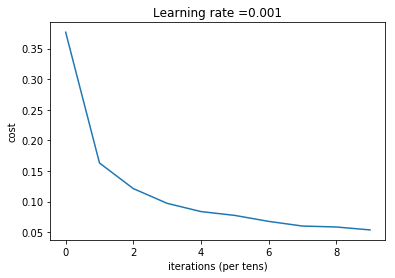

Model saved in path: ./model/train_model.ckpt
Train Accuracy: 0.9801966941746391
Test Accuracy: 0.9666401904854536
prediction after shuffle type is:  <class 'numpy.ndarray'>
y_after_shuffle type is :  <class 'numpy.ndarray'>


In [10]:
_, _, parameters, \
train_prediction_after_shuffle, train_y_after_shuffle,\
 test_prediction_after_shuffle, test_y_after_shuffle,\
    = model(X_train, Y_train, X_test, Y_test, num_epochs=10)
print('prediction after shuffle type is: ', type(train_prediction_after_shuffle[0]))
print('y_after_shuffle type is : ', type(train_y_after_shuffle[0]))

train_prediction_after_shuffle = np.concatenate(train_prediction_after_shuffle).ravel().tolist()
train_y_after_shuffle = np.concatenate(train_y_after_shuffle).ravel().tolist()
test_prediction_after_shuffle = np.concatenate(test_prediction_after_shuffle).ravel().tolist()
test_y_after_shuffle = np.concatenate(test_y_after_shuffle).ravel().tolist()





In [11]:
# confusion_matrix = \
#      tf.contrib.metrics.confusion_matrix(\
#          labels = test_y_after_shuffle, predictions = test_prediction_after_shuffle)
                                        
# # test_recall, _ = tf.Session().run(\
# #      tf.metrics.recall(\
# #          labels = test_y_after_shuffle, predictions = test_prediction_after_shuffle)\
# #                                         )




    

# a = tf.Variable(tf.constant(test_prediction_after_shuffle, dtype=tf.int32))
# b = tf.Variable(tf.constant(test_y_after_shuffle, dtype=tf.int32))
# _, test_precision = tf.metrics.precision(labels = b, predictions = a)
# _, test_recall= tf.metrics.recall(labels = b, predictions = a)


# init_g = tf.global_variables_initializer()
# init_l = tf.local_variables_initializer()
# with tf.Session() as sess:
#     sess.run(init_g)
#     sess.run(init_l)
#     recall = sess.run(test_recall)
#     precision = sess.run(test_precision)
#     confusion_matrix = sess.run(confusion_matrix)
    

# print('confusion matrix is: ', confusion_matrix)
# print('recall is: ', recall)
# print('precision is: ', precision)

                                        

In [12]:
tf.reset_default_graph()

# Create some variables.

def get_params():
    W1 = tf.get_variable("W1", [5, 5, 1, 32])
    W2 = tf.get_variable("W2", [5, 5, 32, 64])
    W3 = tf.get_variable("W3", [5, 5, 64, 64])
    W4 = tf.get_variable("W4", [5, 5, 64, 64])
    W5 = tf.get_variable("W5", [5, 5, 64, 64])
    W6 = tf.get_variable("W6", [5, 5, 64, 64])
    W7 = tf.get_variable("W7", [5, 5, 64, 64])
    W8 = tf.get_variable("W8", [5, 5, 64, 64])
    ### Set up variables for b ###

    parameters = {"W1": W1,
                      "W2": W2,
                      "W3": W3,
                      "W4": W4,
                      "W5": W5,
                      "W6": W6,
                      "W7": W7,
                      "W8": W8,
#                       "b1": b1,
#                       "b2": b2,
#                       "b3": b3,
#                       "b4": b4,
#                       "b5": b5,
#                       "b6": b6,
#                       "b7": b7,
#                       "b8": b8,
                     }
    
    return parameters


parameters = get_params()

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
  # Restore variables from disk.
  saver.restore(sess, "./model/train_model.ckpt")
  print("Model restored.")
  # Check the values of the variables
  print("W1 : %s" % parameters['W1'].eval())
  #print("W2 : %s" % W2.eval())
  print("W2 : %s" % parameters['W2'].eval())
  print("W3 : %s" % parameters['W3'].eval())
  print("W4 : %s" % parameters['W4'].eval())





INFO:tensorflow:Restoring parameters from ./model/train_model.ckpt
Model restored.
W1 : [[[[ 2.50518560e-01  1.03169063e-03  1.16235763e-01  8.44761543e-03
    -2.20481753e-02 -4.96456623e-02  3.47498506e-02  2.28083402e-01
     5.67822382e-02  1.19483232e-01 -2.52125680e-01  1.36647642e-01
     2.07721621e-01 -3.17472816e-02  8.00783653e-03  4.14649472e-02
     1.09815903e-01  4.07569623e-03  1.43313110e-01  1.04010247e-01
    -1.61208063e-01  4.07968201e-02 -2.44146541e-01  6.92336168e-03
    -9.40871164e-02 -1.54901117e-01 -1.20240383e-01  8.84742886e-02
     1.16436966e-01  2.67541464e-02  3.25401910e-02 -5.62619418e-02]]

  [[ 2.57654279e-01  8.72195289e-02  1.81893185e-01  5.03842421e-02
     5.05027873e-03 -1.11868232e-01  6.87247515e-02  1.44229904e-01
     5.12151308e-02  1.33332878e-01 -1.30629703e-01  1.75625011e-01
     2.43918866e-01 -3.53586557e-03 -5.53555377e-02 -2.39682682e-02
     2.51964390e-01 -1.08901478e-01  1.51090520e-02 -1.38846442e-01
     7.47270063e-02 -7.47

W2 : [[[[ 1.33596957e-02 -4.95503917e-02  3.31901871e-02 ... -3.31525467e-02
     3.94122340e-02 -2.23651691e-03]
   [ 3.54286954e-02 -5.40638417e-02  3.15439589e-02 ...  1.81081295e-02
    -1.19225699e-02 -8.23978260e-02]
   [-1.37803033e-02  3.00435349e-02 -3.33731063e-02 ...  1.72303095e-01
     2.72301380e-02 -5.10335527e-02]
   ...
   [ 3.16830091e-02 -1.97149683e-02 -2.37767361e-02 ...  7.93900415e-02
    -2.24905508e-03 -1.81278765e-01]
   [-3.91539298e-02  1.82128139e-02 -1.35958078e-03 ...  2.67379582e-01
    -2.14508250e-02  1.36371851e-01]
   [-2.84562260e-02 -1.85989253e-02  6.11411594e-03 ...  6.33141845e-02
    -3.55690382e-02 -1.07915796e-01]]

  [[ 1.81470569e-02 -5.04983552e-02 -7.84569304e-04 ... -9.20350477e-03
    -5.53384349e-02 -8.51795450e-02]
   [-1.97439790e-02  1.73703171e-02 -4.90291491e-02 ... -2.12479874e-01
    -7.57028069e-03  6.28315751e-03]
   [-2.38837069e-03  3.63323577e-02  2.83504371e-02 ... -1.74036145e-01
    -6.16006106e-02  2.68905424e-02]
   ..